In [36]:
from sympy import *
init_printing()

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv'

# Adjust these column names as needed.
date_col = 'time'
target_col = 'KarupBro'
# List of meteorological features from DMI – update if needed.
input_cols = [
    'temp_min_daily', 'temp_max_daily', 'temp_mean_daily', 
    'temp_grass_mean_daily', 'temp_soil_min_daily', 'temp_soil_max_daily', 
    'temp_soil_mean_daily', 'humidity_daily', 'wind_direction_daily', 
    'wind_speed_daily', 'wind_gust_max_daily', 'precip_total_daily', 
    'precip_duration_daily', 'radiation_global_daily', 
    'sunshine_duration_daily'
]


# Read the CSV
df = pd.read_csv(DATA_PATH, parse_dates=[date_col])
df.sort_values(date_col, inplace=True)
df.reset_index(drop=True, inplace=True)

# Optional: Set the date column as index (if needed)
df.set_index(date_col, inplace=True)

df.tail()

,temp_min_daily,temp_max_daily,temp_mean_daily,temp_grass_mean_daily,temp_soil_min_daily,temp_soil_max_daily,temp_soil_mean_daily,humidity_daily,wind_direction_daily,wind_gust_max_daily,wind_speed_daily,precip_total_daily,precip_duration_daily,radiation_global_daily,sunshine_duration_daily,KarupBro
time,,,,,,,,,,,,,,,,
2023-12-20,0.8,4.4,3.141667,2.316667,5.1,5.4,5.241667,88.583333,252.000000,12.2,2.541667,0.4,4.0,349.0,111.0,4448.18
2023-12-21,1.4,8.7,5.316667,4.637500,5.0,5.3,5.141667,86.083333,254.666667,22.5,5.329167,19.9,159.0,270.0,29.5,5602.14
2023-12-22,0.1,4.0,2.395833,1.129167,4.0,5.1,4.533333,66.000000,293.416667,19.1,5.020833,0.6,3.0,749.0,294.5,6636.60
2023-12-23,-1.6,3.3,0.833333,-0.250000,3.6,4.1,3.754167,88.000000,264.000000,10.5,2.379167,0.8,4.0,589.0,247.0,5809.15
2023-12-24,-0.3,2.1,1.120000,0.700000,3.4,3.6,3.520000,97.700000,136.500000,6.6,1.500000,5.0,38.0,9.0,0.0,5197.78


In [38]:
# Replace outliers with NaN
df.loc[df["temp_mean_daily"] > 35, "temp_mean_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["temp_mean_daily"] = df["temp_mean_daily"].ffill()

# Replace outliers with NaN
df.loc[df["precip_total_daily"] > 100, "precip_total_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["precip_total_daily"] = df["precip_total_daily"].ffill()

Text(0.5, 1.0, 'Daily inflow and rainfall')

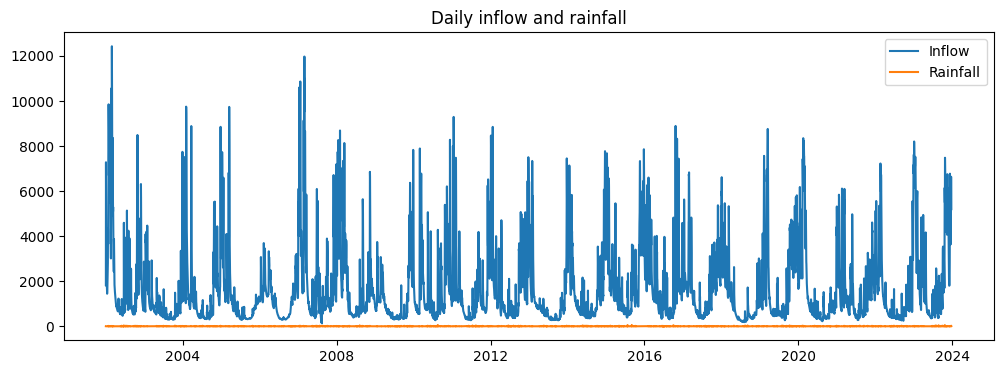

In [39]:
plt.figure(figsize=(12, 4))
plt.plot(df['KarupBro'], label='Inflow')
plt.plot(df['precip_total_daily'], label='Rainfall')
plt.legend(); plt.title('Daily inflow and rainfall')

In [40]:
# Arealet i m²
area_km2 = 178.2
area_m2 = area_km2 * 1e6

# Nedbør i mm → meter
df['precip_m'] = df['precip_total_daily'] / 1000

# Volumen nedbør over oplandet (m³)
df['precip_volume'] = df['precip_m'] * area_m2

df['KarupBro_m3_day'] = df['KarupBro'] * 86.4

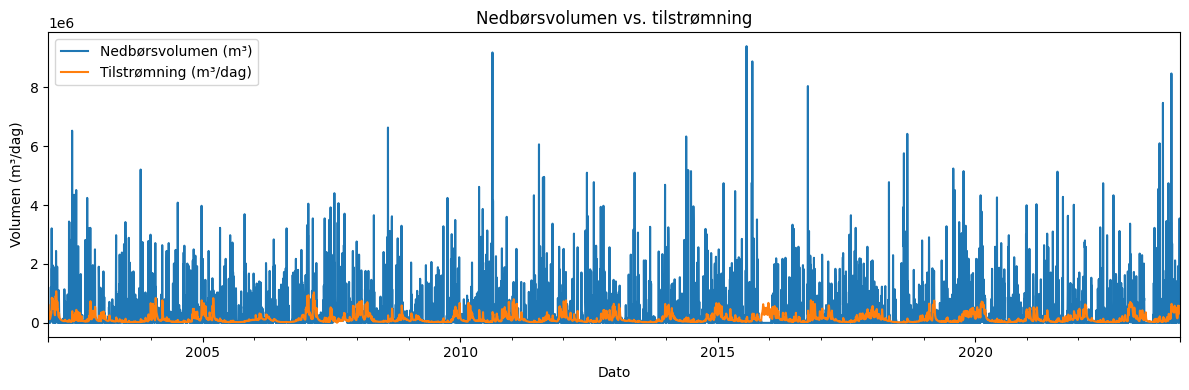

In [41]:
# # only plot the last year
# start_date = df.index[-1] - pd.DateOffset(years=1)
# df = df[df.index >= start_date]

plt.figure(figsize=(12, 4))
df['precip_volume'].plot(label='Nedbørsvolumen (m³)')
df['KarupBro_m3_day'].plot(label='Tilstrømning (m³/dag)')
plt.legend()
plt.title("Nedbørsvolumen vs. tilstrømning")
plt.ylabel("Volumen (m³/dag)")
plt.xlabel("Dato")
plt.tight_layout()
plt.show()

In [42]:
df['runoff_ratio'] = df['KarupBro_m3_day'] / df['precip_volume']

df['runoff_ratio'] = df['KarupBro_m3_day'] / df['precip_volume']
df['runoff_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

# compute the mean runoff ratio
mean_runoff_ratio = df['runoff_ratio'].mean()
print(f"Mean runoff ratio: {mean_runoff_ratio:.2f}")

Mean runoff ratio: 1.57


In [43]:
df['precip_volume_lag1'] = df['precip_volume'].shift(1)
df['runoff_ratio_lag1'] = df['KarupBro_m3_day'] / df['precip_volume_lag1']
df['runoff_ratio_lag1'].replace([np.inf, -np.inf], np.nan, inplace=True)
# compute the mean runoff ratio
mean_runoff_ratio_lag1 = df['runoff_ratio_lag1'].mean()
print(f"Mean runoff ratio lag1: {mean_runoff_ratio_lag1:.2f}")

# lag2
df['precip_volume_lag2'] = df['precip_volume'].shift(2)
df['runoff_ratio_lag2'] = df['KarupBro_m3_day'] / df['precip_volume_lag2']
df['runoff_ratio_lag2'].replace([np.inf, -np.inf], np.nan, inplace=True)
# compute the mean runoff ratio
mean_runoff_ratio_lag2 = df['runoff_ratio_lag2'].mean()
print(f"Mean runoff ratio lag2: {mean_runoff_ratio_lag2:.2f}")

Mean runoff ratio lag1: 1.45
Mean runoff ratio lag2: 1.48


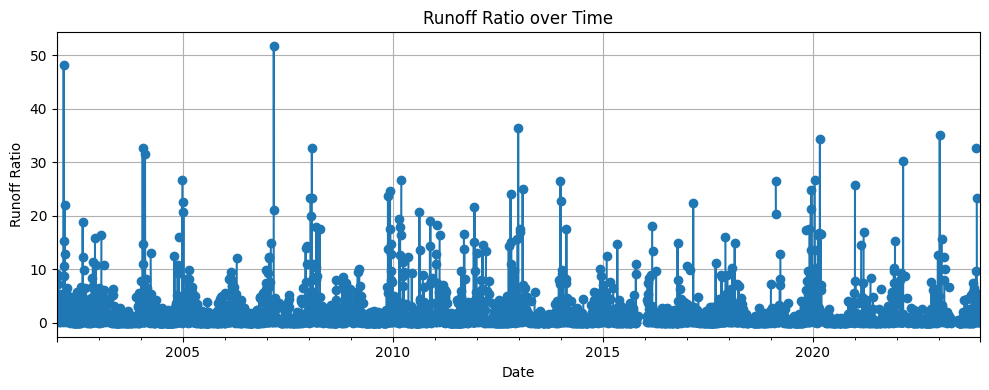

In [50]:
# Plot runoff ratio
plt.figure(figsize=(10, 4))
df['runoff_ratio'].plot(marker='o')
plt.title('Runoff Ratio over Time')
plt.ylabel('Runoff Ratio')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

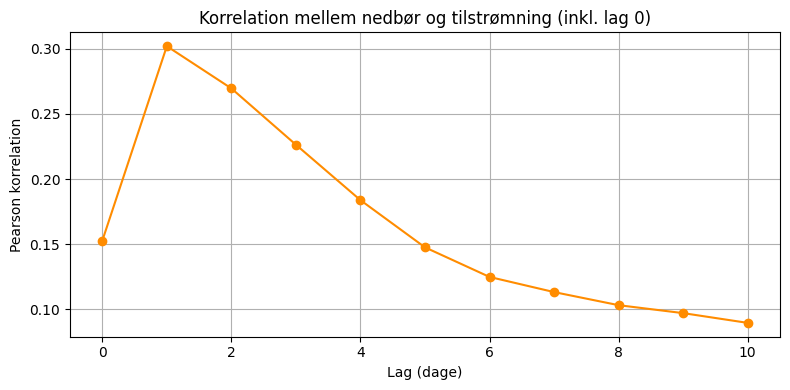

In [ ]:
# Beregn korrelation også for lag 0 (samtidig nedbør og tilstrømning)
max_lag = 10
lags = list(range(0, max_lag + 1))
correlations = []

for lag in lags:
    shifted_precip = df['precip_volume'].shift(lag)
    valid = (shifted_precip.notna()) & (df['KarupBro_m3_day'].notna())
    corr = df.loc[valid, 'KarupBro_m3_day'].corr(shifted_precip[valid])
    correlations.append(corr)

# Plot med lag 0 inkluderet
plt.figure(figsize=(8, 4))
plt.plot(lags, correlations, marker='o', color='darkorange')
plt.title("Korrelation mellem nedbør og tilstrømning (inkl. lag 0)")
plt.xlabel("Lag (dage)")
plt.ylabel("Pearson korrelation")
plt.grid(True)
plt.tight_layout()
plt.show()
